<a href="https://colab.research.google.com/github/turtler12/CV_Homework/blob/main/pset4_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.8300/6.8301 Network Interpretability and Training


In this problem set, we will begin by examining how we can visualize the learned features of a pretrained image classifier to better understand how it makes a decision when classifying a particular scene.

Then, you'll train your own simple image classifier and work to improve its performance as much as you can.


# Requirements installation


First, let's install everything needed to run this notebook


In [ ]:
!pip install Pillow
!pip install -U image
!pip install opencv-python
!pip install tqdm
!pip install torch
!pip install torchvision

from tqdm import tqdm
from io import BytesIO

import cv2
import numpy as np
import PIL.Image
from IPython.display import Image, clear_output, display
import matplotlib.pyplot as plt

# PyTorch will be out main tool for playing with neural networks
import torch
import torch.hub
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms

# For reproducibility
torch.manual_seed(1234)

# CPU / GPU
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

# Download function for model
import requests
def download(url, fn=None):
    if fn is None:
        fn = url.split('/')[-1]
    r = requests.get(url)
    if r.status_code == 200:
        open(fn, 'wb').write(r.content)
        print("{} downloaded: {:.2f} KB".format(fn, len(r.content) / 1024.0))
    else:
        print("url not found:", url)



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 73.1 MB/s eta 0:00:00
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=1e5d280ec73b42320ec704ac3b34bb14b118320256d698b6765f73177c4da437
  Stored in directory: /root/.cache/pip/wheels/62/40/4f/3c9a8d0f22a1a6f966975a460e5cb509a1e7dc42e2ce5d9a6d
Successfully built image
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

We will load PyTorch, our main tool to play with neural networks.


# Loading Images and PyTorch models


Once, we have loaded all the relevant libraries, we will load the model. We will begin with a scene classification model trained on the Places dataset with a ResNet-50 architecture.




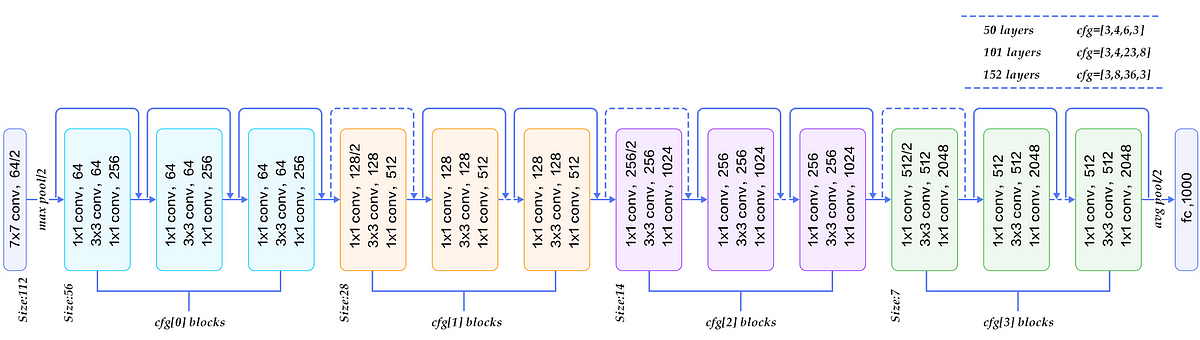

In [ ]:
# Download the pretrained weights
download('http://6.8300.csail.mit.edu/sp23/psets/pset4/resnet50_places365.pth.tar')

# Initialize the model
resnet = models.resnet50(num_classes=365)

# Load the model
sd = torch.load('resnet50_places365.pth.tar', map_location=device)['state_dict']

# Don't worry about this -- when you train a model using parallelism, the
# weights begin with model. We have 1 cpu/gpu, so we will fix the name keys
sd = {k.replace('module.', ''): v for k, v in sd.items()}

# Load weights into network
resnet.load_state_dict(sd)

# Important: put network into evaluation mode
# Some networks have layers that do not behave the same during train/eval
# Forgetting this is a very common source of bugs
resnet.eval()

resnet50_places365.pth.tar downloaded: 94990.39 KB


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Problem 1: Visualizing Network Filters


## Problem 1a: Normalize filters

Now, let's write a function to visualize the filters. You have to complete the following code, with one line normalizing the filter values:


torch.Size([64, 3, 7, 7])
Visualizing conv1 filter 0
tensor(-0.3864) tensor(0.2272)
0 255


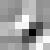

Visualizing conv1 filter 1
tensor(-0.2808) tensor(0.2280)
0 255


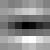

Visualizing conv1 filter 2
tensor(-0.4255) tensor(0.4087)
0 255


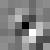

Visualizing conv1 filter 3
tensor(-0.2906) tensor(0.3927)
0 255


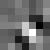

Visualizing conv1 filter 4
tensor(-0.2573) tensor(0.2658)
0 255


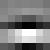

Visualizing conv1 filter 5
tensor(-0.3512) tensor(0.2674)
0 255


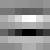

Visualizing conv1 filter 6
tensor(-0.0370) tensor(0.0872)
0 255


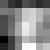

Visualizing conv1 filter 7
tensor(-0.2836) tensor(0.3681)
0 255


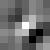

Visualizing conv1 filter 8
tensor(-0.1836) tensor(0.1868)
0 255


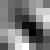

Visualizing conv1 filter 9
tensor(-0.1304) tensor(0.3293)
0 255


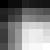

Visualizing conv1 filter 10
tensor(-0.0162) tensor(0.0796)
0 255


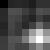

Visualizing conv1 filter 11
tensor(-0.1016) tensor(0.0509)
0 255


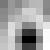

Visualizing conv1 filter 12
tensor(-0.0319) tensor(0.0848)
0 255


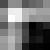

Visualizing conv1 filter 13
tensor(-0.4205) tensor(0.4031)
0 255


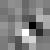

Visualizing conv1 filter 14
tensor(-0.2407) tensor(0.2374)
0 255


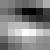

Visualizing conv1 filter 15
tensor(-0.2242) tensor(0.0965)
0 255


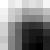

Visualizing conv1 filter 16
tensor(-0.0650) tensor(0.1230)
0 255


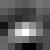

Visualizing conv1 filter 17
tensor(-0.0013) tensor(0.0040)
0 255


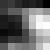

Visualizing conv1 filter 18
tensor(-0.0220) tensor(0.0367)
0 255


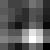

Visualizing conv1 filter 19
tensor(-0.0874) tensor(0.1354)
0 255


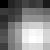

Visualizing conv1 filter 20
tensor(-0.0095) tensor(0.0504)
0 255


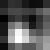

Visualizing conv1 filter 21
tensor(-0.1580) tensor(0.0495)
0 255


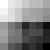

Visualizing conv1 filter 22
tensor(-0.3754) tensor(0.2758)
0 255


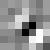

Visualizing conv1 filter 23
tensor(-0.1715) tensor(0.1510)
0 255


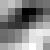

Visualizing conv1 filter 24
tensor(-0.3755) tensor(0.2770)
0 255


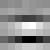

Visualizing conv1 filter 25
tensor(-0.0135) tensor(0.0159)
0 255


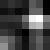

Visualizing conv1 filter 26
tensor(-0.0362) tensor(0.0480)
0 255


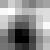

Visualizing conv1 filter 27
tensor(-0.2073) tensor(0.1897)
0 255


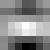

Visualizing conv1 filter 28
tensor(-0.1961) tensor(0.2241)
0 255


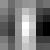

Visualizing conv1 filter 29
tensor(-0.4556) tensor(0.3448)
0 255


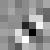

In [ ]:
def showarray(a, fmt='jpeg'):
    ''' Helper function. Use this to show your filters

    Converting to standard image format is a common task that produces garbage
    images when not done correctly. We've provided the correct conversions'''
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def normalize_tensor(tensor):
    # TODO (1a): Normalize between 0 and 255, format as np.uint8
    print(tensor.min(), tensor.max()) #check tensor min and max values
    ans = (tensor - tensor.min()) / (tensor.max() - tensor.min()) * 255 # normalizing
    ans = ans.cpu().numpy().astype(np.uint8)
    print(ans.min(), ans.max()) #should be 0 and 255
    return ans

print(resnet.conv1.weight.data.size())  # Print the size of conv1 weights

# Display the filters of the initial convolutional layer:
for i in range(30):
    print('Visualizing conv1 filter', i)
    weight = resnet.conv1.weight.data[i, 0, :, :]
    # weight = resnet.conv1.weight.data[i, 1, :, :] ## color channels
    # weight = resnet.conv1.weight.data[i, 2, :, :] ## color channels
    normed = normalize_tensor(weight)

    # Resize
    normed = cv2.resize(normed, (50, 50), interpolation=cv2.INTER_NEAREST)
    showarray(normed)


## Problem 1b: Visualize filters for another convolutional layer in ResNet


torch.Size([64, 64, 3, 3])
Visualizing layer1[0].conv2 filter 0
tensor(-6.9258e-06) tensor(7.6027e-06)
0 255


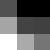

Visualizing layer1[0].conv2 filter 1
tensor(-4.3097e-06) tensor(2.3002e-06)
0 255


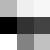

Visualizing layer1[0].conv2 filter 2
tensor(-4.2683e-06) tensor(2.3926e-06)
0 255


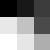

Visualizing layer1[0].conv2 filter 3
tensor(-1.8609e-05) tensor(2.4063e-05)
0 255


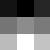

Visualizing layer1[0].conv2 filter 4
tensor(-8.1581e-06) tensor(1.2620e-05)
0 255


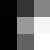

Visualizing layer1[0].conv2 filter 5
tensor(-3.0146e-06) tensor(6.3605e-06)
0 255


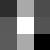

Visualizing layer1[0].conv2 filter 6
tensor(-3.1309e-06) tensor(6.0406e-06)
0 255


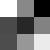

Visualizing layer1[0].conv2 filter 7
tensor(-9.3933e-06) tensor(1.2194e-05)
0 255


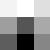

Visualizing layer1[0].conv2 filter 8
tensor(-6.4851e-07) tensor(3.3637e-06)
0 255


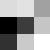

Visualizing layer1[0].conv2 filter 9
tensor(-9.4104e-06) tensor(8.8278e-06)
0 255


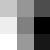

Visualizing layer1[0].conv2 filter 10
tensor(-1.0418e-05) tensor(5.3957e-06)
0 255


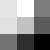

Visualizing layer1[0].conv2 filter 11
tensor(-4.6775e-06) tensor(3.2554e-06)
0 255


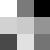

Visualizing layer1[0].conv2 filter 12
tensor(-9.1831e-06) tensor(1.9187e-05)
0 255


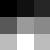

Visualizing layer1[0].conv2 filter 13
tensor(-1.0021e-06) tensor(5.1887e-07)
0 255


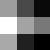

Visualizing layer1[0].conv2 filter 14
tensor(-2.5020e-06) tensor(3.8071e-06)
0 255


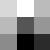

Visualizing layer1[0].conv2 filter 15
tensor(3.9069e-08) tensor(3.5232e-07)
0 255


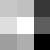

Visualizing layer1[0].conv2 filter 16
tensor(-1.7656e-06) tensor(4.4064e-06)
0 255


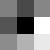

Visualizing layer1[0].conv2 filter 17
tensor(-2.8841e-06) tensor(-1.2663e-06)
0 255


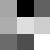

Visualizing layer1[0].conv2 filter 18
tensor(-8.8377e-06) tensor(1.1094e-05)
0 255


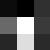

Visualizing layer1[0].conv2 filter 19
tensor(-5.3533e-06) tensor(4.9767e-06)
0 255


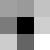

Visualizing layer1[0].conv2 filter 20
tensor(-1.4352e-05) tensor(1.2389e-05)
0 255


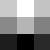

Visualizing layer1[0].conv2 filter 21
tensor(-2.6422e-06) tensor(2.9212e-07)
0 255


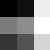

Visualizing layer1[0].conv2 filter 22
tensor(-2.7976e-06) tensor(5.0012e-06)
0 255


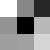

Visualizing layer1[0].conv2 filter 23
tensor(-1.5366e-06) tensor(3.8889e-06)
0 255


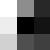

Visualizing layer1[0].conv2 filter 24
tensor(-7.0416e-07) tensor(3.1243e-06)
0 255


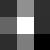

Visualizing layer1[0].conv2 filter 25
tensor(-1.3612e-05) tensor(1.9990e-05)
0 255


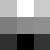

Visualizing layer1[0].conv2 filter 26
tensor(-3.3203e-09) tensor(2.6588e-09)
0 255


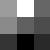

Visualizing layer1[0].conv2 filter 27
tensor(-7.6729e-09) tensor(8.1621e-09)
0 255


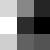

Visualizing layer1[0].conv2 filter 28
tensor(-2.1255e-06) tensor(7.0040e-07)
0 255


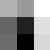

Visualizing layer1[0].conv2 filter 29
tensor(-2.6507e-06) tensor(2.9235e-07)
0 255


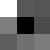

In [ ]:
# TODO (1b): pick a different layer to analyze
#3×3 conv from the first block in layer1
# [64, 64, 3, 3] i think for resnt 50
print(resnet.layer1[0].conv2.weight.data.size())

for i in range(30):
    print('Visualizing layer1[0].conv2 filter', i)
    weight = resnet.layer1[0].conv2.weight.data[i, 0, :, :]
    normed = normalize_tensor(weight)
    normed = cv2.resize(normed, (50, 50), interpolation=cv2.INTER_NEAREST)
    showarray(normed)



# Predicting classes with a pre-trained model


To make the process easier to read, we will load the label <--> index assignment for the Places dataset and one image to use throughout the pset


rio.jpg downloaded: 178.28 KB


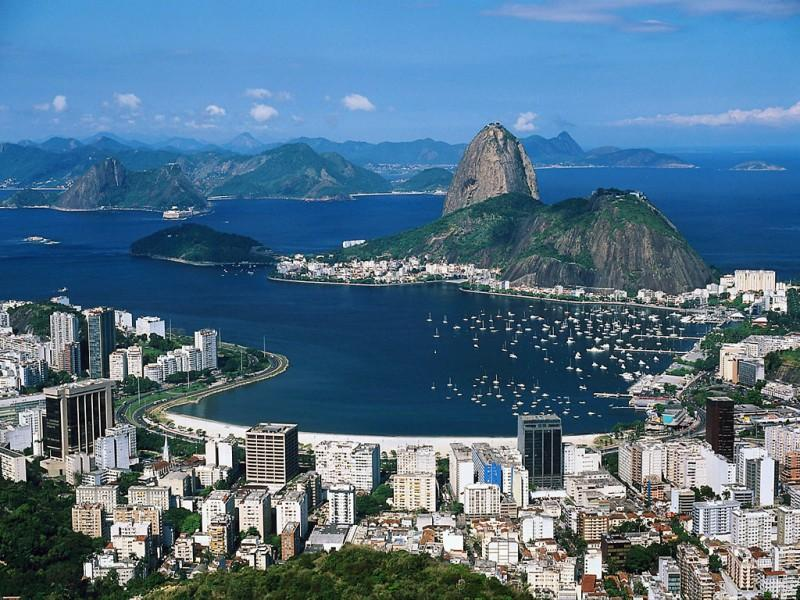

In [ ]:
from urllib.request import urlopen

synset_url = 'http://gandissect.csail.mit.edu/models/categories_places365.txt'
classlabels = [
    r.split(' ')[0][3:] for r in urlopen(synset_url).read().decode('utf-8').split('\n')
]


from torchvision import transforms

download('http://6.869.csail.mit.edu/fa19/miniplaces_part1/rio.jpg')
img_pil = PIL.Image.open('rio.jpg').convert('RGB')
img_numpy = np.array(img_pil)
showarray(img_numpy)

First, let's take a look at the raw prediction of the model.


In [ ]:
# data preprocessing: resize an image, change it from a PIL image to a pytorch tensor, normalize it according to dataset statistics
center_crop = transforms.Compose(
    [
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# our model can only take input that is preprocessed, so preprocess our loaded image
img_tensor = center_crop(img_pil)
logits = resnet(img_tensor.unsqueeze(0)).squeeze()
# get the indices associated with the topk logits
categories = logits.topk(5)[1]

# print the labels corresponding to the topk indices
print(categories)
print(', '.join([classlabels[cat] for cat in categories]))


tensor([348, 194,  49,  97, 171])
village, islet, beach_house, coast, harbor


# Problem 2: Visualizing Internal Activations of the Network

Let's look at what parts of the image cause different units to activate (send some positive signal). All of these activations combine to inform the final inference.

The convolutional layers of ResNet essentially make a semantic representation of what is contained in the image. This is followed by two fully connected layers, which use the information from that representation to categorize the image.

So, let's remove the last few layers (which do classification) to get the underlying representation, and we'll visualize the activations that went into that representation from different units


## Problem 2a: Remove layers

In [ ]:
def generate_featuremap_unit(model_cut, unit_id, im_input):
    # Extract activation from model
    # Mark the model as being used for inference
    model_cut.eval()
    # Crop the image
    im = center_crop(im_input)
    # Place the image into a batch of size 1, and use the model to get an intermediate representation
    activations = model_cut(im.unsqueeze(0))
    # Print the shape of our representation
    print(activations.size())
    # Extract the only result from this batch, and take just the `unit_id`th channel
    # Return this channel
    return activations.squeeze()[unit_id]

def visualize_featuremap(im_input, feature_map, alpha=0.3):
    # Normalize to [0..1], with a little leeway (0.9999) in case feature_map has 0 range
    feature_map = feature_map / (feature_map.max() + 1e-10)
    # Convert to numpy (detach() just seperates a tensor from the gradient)
    feat_numpy = feature_map.detach().numpy()
    # Resize the feature map to our original image size (our strided conv layers reduce the size of the image)
    feat_numpy = cv2.resize(feat_numpy, (im_input.shape[1], im_input.shape[0]))
    # Invert to make the heatmap look more natural
    map_t = 1 - feat_numpy
    # Add an extra dimension to make this a [H,W,C=1] image
    feat_numpy = np.expand_dims(feat_numpy, axis=2)

    # Convert to image (UINT8 from 0-255)
    map_t = 255 * map_t
    map_t = map_t.astype(np.uint8)
    # Use a color map to change this from BW to a nice color
    map_t = cv2.applyColorMap(map_t, cv2.COLORMAP_JET)
    # Combine the heatmap with the original image so you can see which section of the image is activated
    im_final = np.multiply((alpha * im_input + (1 - alpha) * map_t), feat_numpy) + np.multiply(
        im_input, 1 - feat_numpy
    )
    # Return final visualization
    return im_final


def remove_last_layers(model, num_layers=2):
    # TODO (2a): remove the last 2 layers of resnet
    # Note: the .children() function of nn.Module
    # (which resnet50 inherits from) and nn.Sequential() will be useful
    layers = list(model.children())
    # remove relavent sections -  average pool and fc)
    truncated_layers = layers[:-num_layers]
    model_cut = nn.Sequential(*truncated_layers)
    return model_cut

model_cut = remove_last_layers(resnet, num_layers=2)

## Problem 2b: Deactivate units

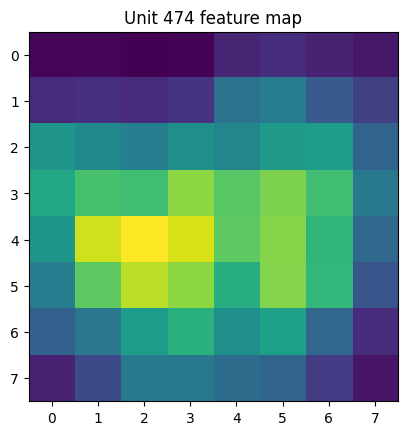

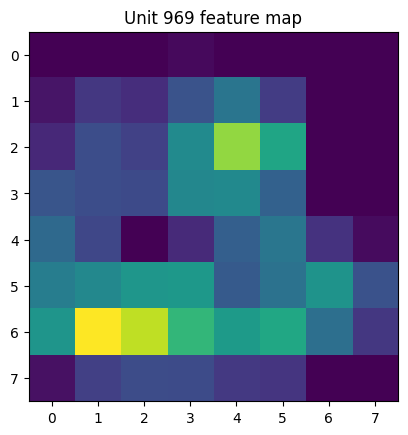

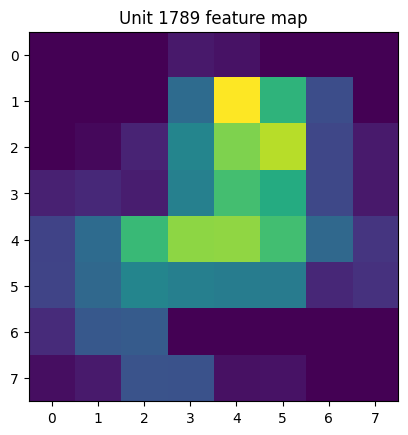

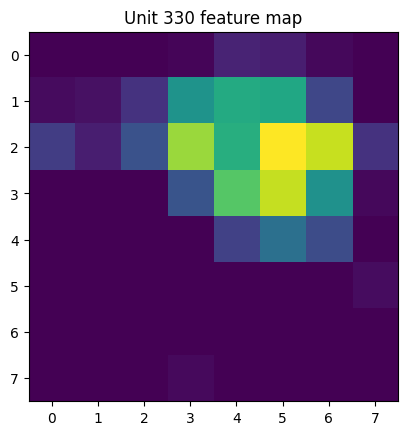

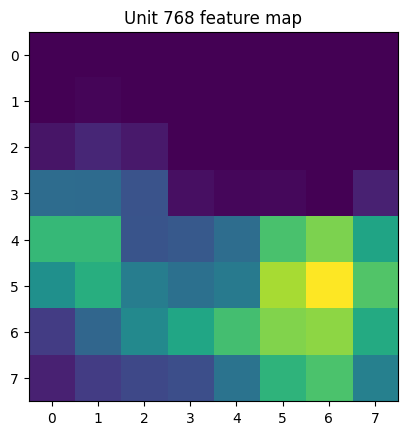

Original top 5 class names  ['village', 'islet', 'beach_house', 'coast', 'harbor']
Original top 5 class values  [8.4416    8.382955  7.7612643 6.9516244 6.809723 ]
Modified top 5 class names  ['islet', 'beach_house', 'village', 'coast', 'harbor']
Modified top 5 class values  [8.094032 7.247253 7.189238 6.60195  6.503104]


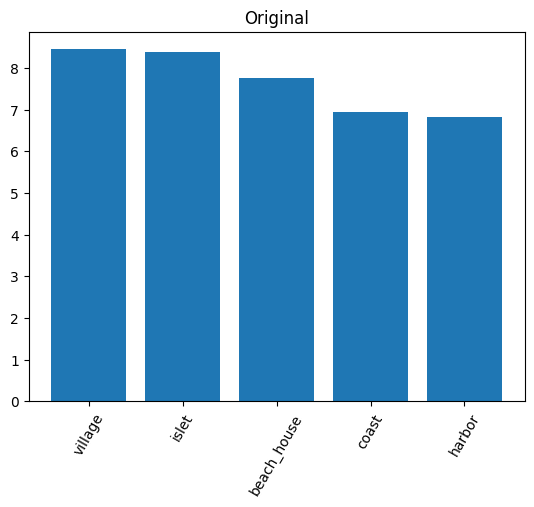

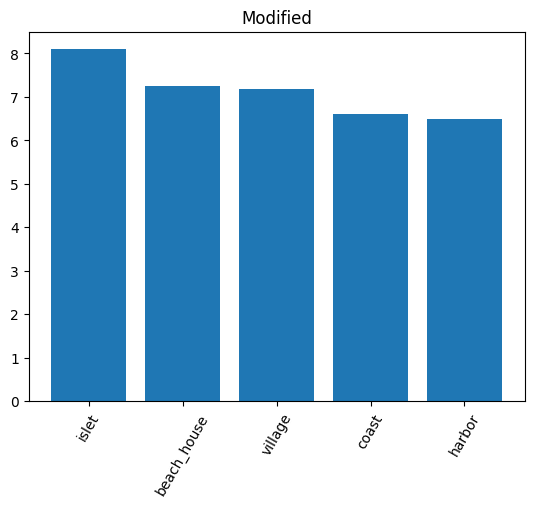

In [ ]:
# TODO (2b) Find the unit index that has the maximum weights
# in the fully connected layer and deactivate that unit.
# Compare the orginal prediction and the new prediction
out_original = resnet(img_tensor.unsqueeze(0)).squeeze() # original prediction
class_ids = np.argsort(-out_original.data.cpu().numpy())[0]
index = torch.topk(resnet.fc.weight[class_ids, :], k=5)[1]



def deactivate_unit_activations(model_cut, image, unit_id):
    """
    1. Pass 'image' through 'model_cut' to get features of shape (1, #units, H, W).
    2. Zero out the channels in 'unit_id'.
    3. Pass the modified features through resnet.avgpool and resnet.fc to get final logits.
    4. Return the modified logits, and optionally show the feature maps you zeroed out.
    """
    # TODO: Get the output features for this model. Feature shape should be (1, # units, H, W)
    model_cut.eval()
    resnet.eval()

    # getting the features after ignoring the weights
    with torch.no_grad():
        feats = model_cut(image.unsqueeze(0))  # shape: (1, #units, H, W)

    # TODO: deactivate the unit index that has the maximum weights (Set all values for that unit to 0)
    # show + zero relavent weights
    for i, unit_idx in enumerate(unit_id):
        # channel's 2d activation function
        feature_map = feats[0, unit_idx, :, :].cpu().numpy()
        # plotting
        plt.imshow(feature_map)
        plt.title(f"Unit {unit_idx} feature map")
        plt.show()

        # set everything to 0
        feats[0, unit_idx, :, :] = 0


    # TODO: run the modified features through the last two layers of the original network
    # pass the modified features into the last two layers
    # which are avgpool -> flatten -> fc
    # shape: (1, #units, 1, 1)
    x = resnet.avgpool(feats)
    # shape: (1, #units)
    x = torch.flatten(x, 1)
    # shape: (1, #classes)
    out_modified = resnet.fc(x)

    return out_modified


def plot_top_classes(values, top_k=5, title=None):
    sorted_classes = np.argsort(-values)
    class_ids = sorted_classes[:top_k]
    class_names = [classlabels[it] for it in list(class_ids)]
    class_values = values[class_ids]
    print(title + " top 5 class names ", class_names)
    print(title + " top 5 class values ", class_values)
    plt.bar(class_names, class_values)
    plt.xticks(rotation=60)
    plt.title(title)

out_modified = deactivate_unit_activations(model_cut, img_tensor, index)

plt.figure(0)
plot_top_classes(out_original.data.cpu().numpy().squeeze(), title='Original')

plt.figure(1)
plot_top_classes(out_modified.data.cpu().numpy().squeeze(), title='Modified')


# Problem 3: Visualizing model activations with Class Activation Maps (CAMs)


Once we have load the image and the model, now we will explore how to visualize the internal activations of the model. We will start by visualizing which parts of the image are responsibe for the final decision.

![texto alternativo](https://camo.githubusercontent.com/fb9a2d0813e5d530f49fa074c378cf83959346f7/687474703a2f2f636e6e6c6f63616c697a6174696f6e2e637361696c2e6d69742e6564752f6672616d65776f726b2e6a7067)


We create a version of the model without the last two layers, so that we can access the last convolutional layer.


We compute the activations using the Class Activation Mapping for a given output label.


Visualizing category village
torch.Size([2048, 8, 8])
torch.Size([64, 365])


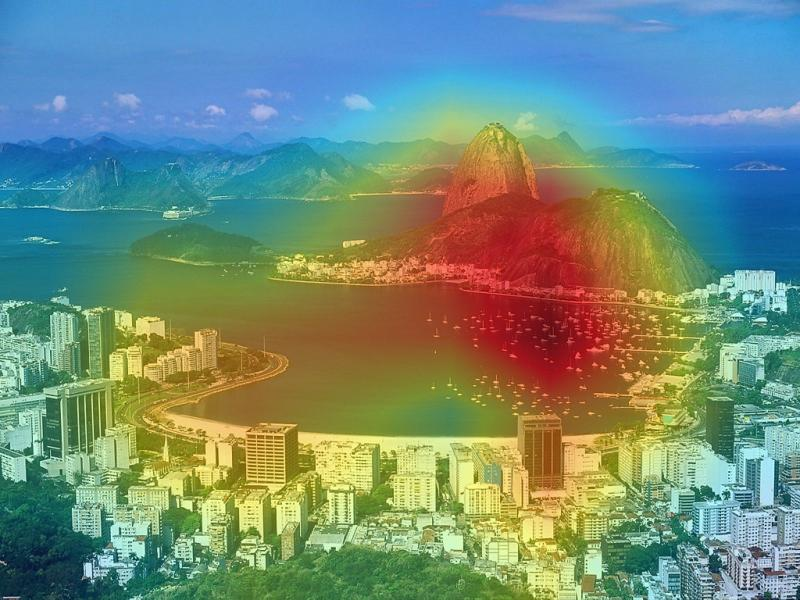

Visualizing category islet
torch.Size([2048, 8, 8])
torch.Size([64, 365])


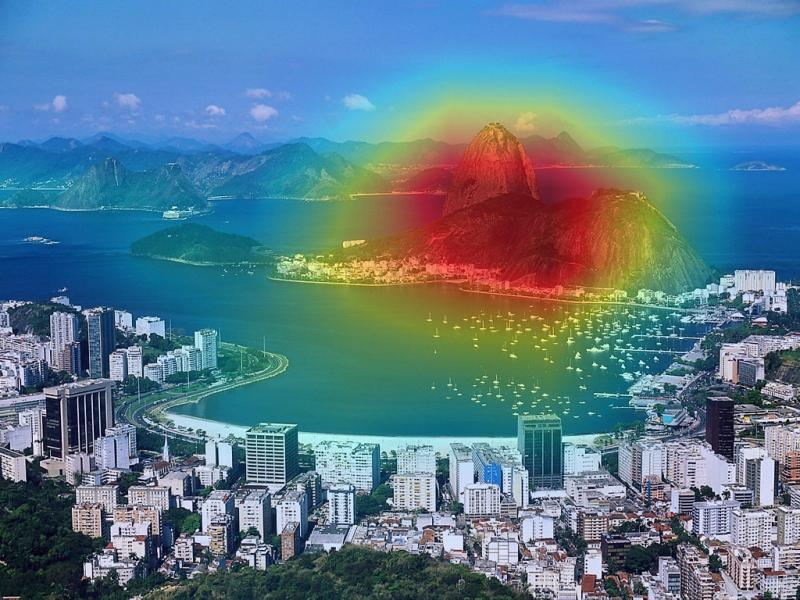

Visualizing category beach_house
torch.Size([2048, 8, 8])
torch.Size([64, 365])


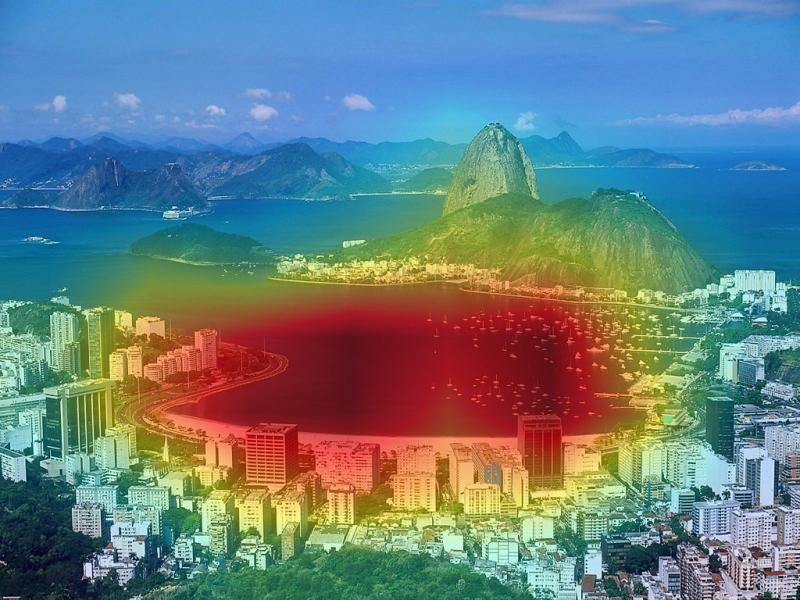

Visualizing category coast
torch.Size([2048, 8, 8])
torch.Size([64, 365])


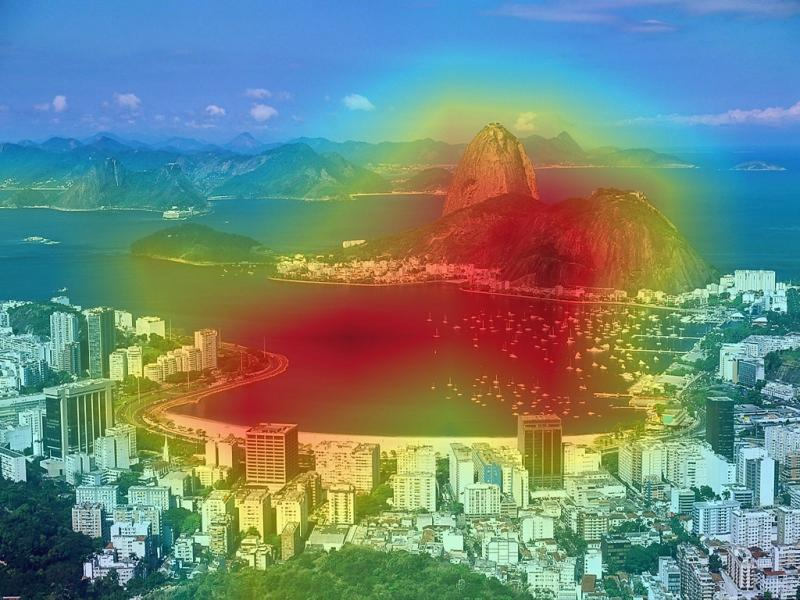

Visualizing category harbor
torch.Size([2048, 8, 8])
torch.Size([64, 365])


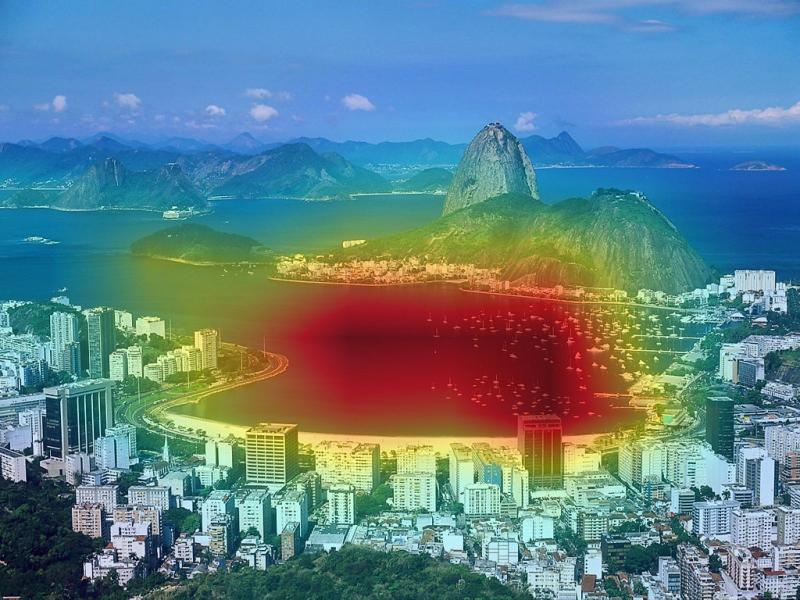

In [ ]:
def generate_featuremap_CAM(model, unit_id, im_input):
    # Extract activation from model
    model.eval()
    im = center_crop(im_input)
    activations = model(im.unsqueeze(0)).squeeze()  # 2048 x h x w
    num_channels, height, width = activations.shape

    # TODO (3a): convert the shape of the output (activations variable) to (h*w) x c
    # Purpose of this question: reshaping (.view) tensors can be tricky. The default
    # ordering of dimensions is usually channel first. You may need to .transpose()
    # to correct for this. This is one of the most common sources of bugs in
    # deep NN implementations
    changed_shape = activations.squeeze(0).view(num_channels, height*width).permute(1, 0)
    #activations = activations.view(height * width, num_channels) produces diff result
    print(activations.shape)

    # TODO (3b): Run the fully connected layer from resnet to compute the weighted average with activations as the input variable
    # out_final should be a (h*w) x 365 tensor.
    out_final = resnet.fc(changed_shape)
    print(out_final.shape)

    # TODO (3c): obtain the class activation map for the corresponding unit_id
    # class_activation_maps should be a 365 x height x width tensor.
    class_activation_maps = out_final.permute(1, 0).view(-1, height, width)
    return class_activation_maps[unit_id]

# Visualize the most activated region in the image for the 5 top classes
for i in range(categories.shape[0]):
    print('Visualizing category', classlabels[categories[i]])
    feat = generate_featuremap_CAM(model_cut, categories[i].item(), img_pil)
    im_result = visualize_featuremap(img_numpy, feat)
    showarray(im_result)

# Problem 4: Training your own CNN classifier

The goal of this problem is to train a small convolutional neural network to classify images of clothing items from the FashionMNIST dataset. You'll first fill in critical components of a simple PyTorch training pipeline, evaluate the model on the test set, and explore the impact of specific design choices and hyperparameters on the model's performance.

## Building an FashionMNIST Classifier

Using what we have learned, let's build a simple FasionMNIST classifier. Each element of the dataset is a 2-tuple: the 28x28 image and its label.


The [`torchvision`](https://pytorch.org/docs/stable/torchvision/index.html) library provides a wide range of standard vision datasets and networks with pretrained weights. We will use [the `torchvision.datasets.FashionMNIST` class](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) to easily access the FasionMNIST dataset.

In deep learning, it is often a good idea to normalize network inputs to be centered around zero. We use the [`torchvision.transforms.Normalize`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) tranform to achieve this. We compose the transforms together using the [`torchvision.transforms.Compose`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose) transform, which allows us to apply multiple transforms sequentially. We provide the following functions to help create the FashionMNIST dataset with these transforms:

In [ ]:
def get_transform(split='train'):

    return transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    )
    """
    if split == 'train':
        return transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
    """

def get_dataset(split='train', transform=None):
    """
    return datasets.FashionMNIST(
        'data',
        train=split == 'train',
        download=True,
        transform=transform if transform is not None else transforms.ToTensor(),
    )
    """
    return datasets.FashionMNIST(
        root='data',
        train=(split=='train'),
        download=True,
        transform=transform if transform else transforms.ToTensor()
    )

def get_dataloaders(batch_size=64, num_workers=2):
    '''Use Pytorch torch.utils.data.DataLoader to load batched data'''
    train_dataset = get_dataset('train', get_transform())
    val_dataset = get_dataset('val', get_transform())
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,  # shuffle training set
        num_workers=num_workers,  # turns on multi-processing loading so training is not blocked by data loading
        pin_memory=True,  # pin_memory allows faster transfer from CPU to GPU
    )
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    return train_dataloader, val_dataloader

print('training set size:\t{}'.format(len(get_dataset('train'))))
print('validation set size:\t{}'.format(len(get_dataset('val'))))

# Each element yielded by `train_loader` (a Python iterable) is still a 2-tuple,
# but now consisting of a batched image tensor, and a batched label tensor.
train_loader, _ = get_dataloaders()
images, labels = next(iter(train_loader))

print('batched image tensor shape: {}'.format(images.shape))
print('batched label tensor shape: {}'.format(labels.shape))

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.27MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.67MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.9MB/s]


training set size:	60000
validation set size:	10000
batched image tensor shape: torch.Size([64, 1, 28, 28])
batched label tensor shape: torch.Size([64])


### Building the Network

We will use a convolutional network for classification. The following architecture is adapted from the famous [LeNet-5](https://ieeexplore.ieee.org/document/726791) [1].

[1] LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.


In [ ]:
class MyNet(nn.Module):
    def __init__(
        self,
        num_classes=10,
        kernel_size=5,
        filter1_size=5,
        filter2_size=16,
        fc1_size=120,
        fc2_size=84,
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=filter1_size,
            kernel_size=kernel_size,
            padding=2,
        )
        self.conv2 = nn.Conv2d(
            in_channels=filter1_size,
            out_channels=filter2_size,
            kernel_size=kernel_size,
        )
        self.fc1 = nn.Linear(in_features=filter2_size * kernel_size ** 2, out_features=fc1_size)
        self.fc2 = nn.Linear(in_features=fc1_size, out_features=fc2_size)
        self.fc3 = nn.Linear(in_features=fc2_size, out_features=num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

net = MyNet().to(device)

# This network output a size 10 vector for each input image, as verified below
# using a random input tensor.
net(torch.randn(32, 1, 28, 28, device=device)).shape


torch.Size([32, 10])

### Problem 4a: Training Loop

For classification, we will use the cross-entropy loss [`F.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) to train this network.

We write a function that accepts a PyTorch dataloader, model and optimizer (as well as a device and current epoch), and trains the net for 1 epoch (one full pass through the training set).

The next exercise is to fill in the code below. You can use the following pytorch functions:

-   put data on GPU: [to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html?highlight=#torch.to)
-   clear gradient: [zero_grad](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html?highlight=zero_grad)
-   backward pass: [backward](https://pytorch.org/docs/stable/generated/torch.autograd.backward.html?highlight=backward#torch.autograd.backward)
-   update parameters with a gradient step: [step](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html?highlight=step#torch.optim.Optimizer.step)


In [ ]:
########################
#                      #
#       Exercise       #
#                      #
########################

# Fix the places with a TODO

def accuracy(output, target):
    """Computes the accuracy of the model on the test set.

    Args:
        output: the output of the model
        target: the ground truth labels
    Returns:
        the accuracy of the model on the test set
    """
    with torch.no_grad():
        _, predicted = torch.max(output, 1)
        correct = (predicted == target).sum().item()
    return correct / len(target)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train(dataloader, model, optimizer, epoch):
    model.train()

    train_loss = []
    acc_meter = AverageMeter()
    batches = tqdm(enumerate(dataloader), total=len(dataloader))
    batches.set_description("Epoch NA: Loss (NA) Accuracy (NA %)")
    for batch_idx, (data, target) in batches:



        # TODO: Move data to appropriate device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        data, target = data.to(device), target.to(device)

        # TODO: Zero out gradients
        optimizer.zero_grad()

        # TODO: Compute forward pass, loss, and gradients
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()

        # TODO: Update parameters
        optimizer.step()

        # TODO: Compute and record accuracy (cf. helper function above)
        # record
        train_loss.append(loss.item())

        # Compute and record accuracy - predictions are argmax of logit
        _, preds = torch.max(output, dim=1)
        correct = (preds == target).sum().item()
        batch_acc = correct / data.size(0)
        acc_meter.update(batch_acc)


        batches.set_description(
            "Epoch {:d}: Loss ({:.2e}), Train Accuracy ({:02.0f}%)".format(
                epoch, loss.item(), 100.0 * acc_meter.avg
            )
        )

    return train_loss, acc_meter.avg



Let's also write a function that evaluates our network on the validation set.


In [ ]:
def evaluate(dataloader, net):
    """ Computes model accuracy on a dataset

    Args:
        dataloader: Eval dataset
        net: model
    Returns:
        accuracy of the model

    """
    total = 0
    correct = 0

    net.eval()
    # puts the network in eval mode. this is important when the
    # network has layers that behaves differently in training and
    # evaluation time, e.g., dropout and batch norm.
    for image, label in dataloader:
        image, label = image.to(device), label.to(device)

        with torch.no_grad():
            # gradients are not tracked in this context manager
            # since we are evaluating, gradients are not needed
            # and we can save some time and GPU memory.

            # Get predictions
            logits = net(image)
            prediction = logits.argmax(dim=-1)

            # Update total and correct
            total += prediction.shape[0]
            correct += (prediction == label).sum()

    return correct / total


In [ ]:
# Without any training, the network accuracy matches that of random guessing: ~10%.
_, val_loader = get_dataloaders(batch_size=32, num_workers=0)
print('At initialization, the network has accuracy {:.4f}%'.format(evaluate(val_loader, net) * 100))


At initialization, the network has accuracy 72.9300%


## Problem 4b: Putting Everything Together


Learning rate: 1e-05
Epoch: 0	Validation Accuracy: 90.0400%


Epoch 0: Loss (1.04e-01), Train Accuracy (96%): 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]


Epoch: 1	Validation Accuracy: 90.5100%


Epoch 1: Loss (6.06e-02), Train Accuracy (97%): 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]


Epoch: 2	Validation Accuracy: 90.6500%


Epoch 2: Loss (7.35e-02), Train Accuracy (97%): 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]


Epoch: 3	Validation Accuracy: 90.6300%


Epoch 3: Loss (6.28e-02), Train Accuracy (97%): 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]


Epoch: 4	Validation Accuracy: 90.6900%


Epoch 4: Loss (6.68e-02), Train Accuracy (97%): 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]


Epoch: 5	Validation Accuracy: 90.6400%


Epoch 5: Loss (7.14e-02), Train Accuracy (97%): 100%|██████████| 469/469 [00:15<00:00, 30.28it/s]


Epoch: 6	Validation Accuracy: 90.6700%


Epoch 6: Loss (9.36e-02), Train Accuracy (97%): 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]


Epoch: 7	Validation Accuracy: 90.7500%


Epoch 7: Loss (7.08e-02), Train Accuracy (97%): 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]


Epoch: 8	Validation Accuracy: 90.7600%


Epoch 8: Loss (8.69e-02), Train Accuracy (97%): 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]


Epoch: 9	Validation Accuracy: 90.7600%


Epoch 9: Loss (9.62e-02), Train Accuracy (97%): 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]


Done! 	Validation Accuracy: 90.7800%
Learning rate: 5e-05
Epoch: 0	Validation Accuracy: 90.7800%


Epoch 0: Loss (9.17e-02), Train Accuracy (97%): 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]


Epoch: 1	Validation Accuracy: 90.8200%


Epoch 1: Loss (4.66e-02), Train Accuracy (97%): 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]


Epoch: 2	Validation Accuracy: 90.9000%


Epoch 2: Loss (5.70e-02), Train Accuracy (97%): 100%|██████████| 469/469 [00:15<00:00, 29.96it/s]


Epoch: 3	Validation Accuracy: 90.8600%


Epoch 3: Loss (6.32e-02), Train Accuracy (97%): 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]


Epoch: 4	Validation Accuracy: 90.8900%


Epoch 4: Loss (9.33e-02), Train Accuracy (97%): 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]


Epoch: 5	Validation Accuracy: 90.9000%


Epoch 5: Loss (8.24e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]


Epoch: 6	Validation Accuracy: 90.9600%


Epoch 6: Loss (5.11e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:16<00:00, 28.21it/s]


Epoch: 7	Validation Accuracy: 90.9300%


Epoch 7: Loss (6.47e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]


Epoch: 8	Validation Accuracy: 90.9100%


Epoch 8: Loss (3.85e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]


Epoch: 9	Validation Accuracy: 90.9000%


Epoch 9: Loss (5.49e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]


Done! 	Validation Accuracy: 90.9300%
Learning rate: 0.0001
Epoch: 0	Validation Accuracy: 90.9300%


Epoch 0: Loss (4.80e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]


Epoch: 1	Validation Accuracy: 91.0000%


Epoch 1: Loss (8.16e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]


Epoch: 2	Validation Accuracy: 91.0100%


Epoch 2: Loss (9.62e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]


Epoch: 3	Validation Accuracy: 90.9600%


Epoch 3: Loss (1.01e-01), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]


Epoch: 4	Validation Accuracy: 90.9000%


Epoch 4: Loss (7.08e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 30.03it/s]


Epoch: 5	Validation Accuracy: 91.0000%


Epoch 5: Loss (5.62e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:16<00:00, 28.01it/s]


Epoch: 6	Validation Accuracy: 90.9400%


Epoch 6: Loss (7.61e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]


Epoch: 7	Validation Accuracy: 91.0000%


Epoch 7: Loss (8.56e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]


Epoch: 8	Validation Accuracy: 90.9800%


Epoch 8: Loss (6.53e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]


Epoch: 9	Validation Accuracy: 90.9800%


Epoch 9: Loss (6.58e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]


Done! 	Validation Accuracy: 91.0600%
Learning rate: 0.0005
Epoch: 0	Validation Accuracy: 91.0600%


Epoch 0: Loss (5.32e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]


Epoch: 1	Validation Accuracy: 91.0200%


Epoch 1: Loss (5.61e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]


Epoch: 2	Validation Accuracy: 90.9800%


Epoch 2: Loss (9.46e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]


Epoch: 3	Validation Accuracy: 91.0000%


Epoch 3: Loss (7.47e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]


Epoch: 4	Validation Accuracy: 90.9200%


Epoch 4: Loss (4.21e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]


Epoch: 5	Validation Accuracy: 90.8700%


Epoch 5: Loss (5.35e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]


Epoch: 6	Validation Accuracy: 90.9500%


Epoch 6: Loss (6.30e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]


Epoch: 7	Validation Accuracy: 90.8900%


Epoch 7: Loss (1.01e-01), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]


Epoch: 8	Validation Accuracy: 90.7300%


Epoch 8: Loss (6.54e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]


Epoch: 9	Validation Accuracy: 90.8100%


Epoch 9: Loss (4.88e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]


Done! 	Validation Accuracy: 90.8400%
Learning rate: 0.001
Epoch: 0	Validation Accuracy: 90.8400%


Epoch 0: Loss (8.28e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]


Epoch: 1	Validation Accuracy: 90.8100%


Epoch 1: Loss (1.71e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]


Epoch: 2	Validation Accuracy: 90.8800%


Epoch 2: Loss (5.14e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]


Epoch: 3	Validation Accuracy: 90.8300%


Epoch 3: Loss (2.62e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]


Epoch: 4	Validation Accuracy: 90.7200%


Epoch 4: Loss (6.15e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]


Epoch: 5	Validation Accuracy: 90.8100%


Epoch 5: Loss (6.84e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]


Epoch: 6	Validation Accuracy: 90.7700%


Epoch 6: Loss (5.62e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]


Epoch: 7	Validation Accuracy: 90.8000%


Epoch 7: Loss (7.53e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.97it/s]


Epoch: 8	Validation Accuracy: 90.7800%


Epoch 8: Loss (2.02e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]


Epoch: 9	Validation Accuracy: 90.5800%


Epoch 9: Loss (4.56e-02), Train Accuracy (98%): 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]


Done! 	Validation Accuracy: 90.7200%


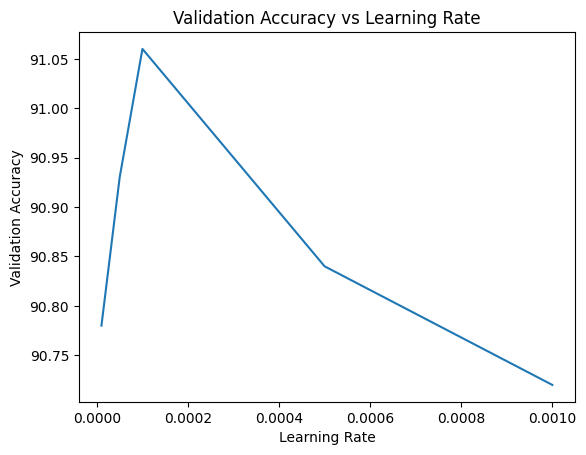

In [ ]:
########################
#                      #
#       Exercise       #
#                      #
########################


# Fix the places with a TODO

num_epochs = 10
lrs = [0.00001, 0.00005, 0.0001, 0.0005, 0.001]
#lrs = [0.00005]
valid_accuracys = []



#def create_optimizer(net, lr):
    #return torch.optim.Adam(net.parameters(), lr=lr)
    #return torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

#optim = create_optimizer(net, lr)
for lr in lrs:
  #optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)
  optim = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
  train_loader, val_loader = get_dataloaders(batch_size=128)
  print('Learning rate: {}'.format(lr))

  for epoch in range(num_epochs):
      print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
      train(train_loader, net, optim, epoch)
  valid_accuracy = evaluate(val_loader, net) * 100
  print('Done! \tValidation Accuracy: {:.4f}%'.format(valid_accuracy))
  valid_accuracys.append(float(evaluate(val_loader, net) * 100))

# plotting a graph of validation accuracy and final train accuracy vs lr
plt.plot(lrs, valid_accuracys)
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate')
plt.show()






## Problem 4c: Tuning the Model


We want you to get a feel for the impact of specific design choices on the performance of the network. Experiment with two or more of the following hyperparameters / techniques:

-   Data augmentation
-   Weight initialization
-   Number of layers, or number of layer features
-   Type of optimizer
-   Learning rate and/or schedule
-   Regularization

For the techniques you choose, plot the top-1 accuracy of your modified network against the top-1 accuracy of the original network for both the training and validation sets. Try several different hyperparameter values! For example, if you choose to modify the learning rate, you can plot a chart of learning rate vs. top-1 accuracy. Briefly describe the techniques you tried, and suggest an explanation for your results. **Full credit will only be given if at least 90% validation accuracy is achieved (i.e., the accuracy must be above 89.9999999%).**

# Problem 5: Train a vision transformer
Now, let's approach the same clothing classification task above, but using transformers instead. We'll be reusing the same dataloaders, optimizer, training, and evaluation functions as in problem 4.

 We'll start by implementing the basic elements of a vision trasformer.

## Problem 5a: Tokenization

Fill in the TODOs below to split each image into patch tokens using a convolutional layer, as detailed [here](https://visionbook.mit.edu/transformers.html#tokenization).

In [ ]:
class Tokenize(nn.Module):
      def __init__(self, patch_size, channels, token_dim):
          super().__init__()
          # TODO (5a): code convolution here
          self.proj = nn.Conv2d(
            in_channels=channels,
            out_channels=token_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

      def forward(self, x):
          # x.shape = (B, C, H, W)
          # out.shape = (B, num_tokens, token_dim)
          # TODO (5a): tokenize
          out = self.proj(x)              # (B, token_dim, H/P, W/P)
          B, D, Hp, Wp = out.shape
          out = out.flatten(2)            # (B, D, Hp*Wp)
          out = out.transpose(1, 2)       # (B, N, D)  with N = Hp*Wp
          return out

## Problem 5b: Attention

Now, implement a single attention head. Refer to equation 26.6 in [this section of the book](https://visionbook.mit.edu/transformers.html#self-attention), and make sure to store the attention matrix $A$ in variable A and $T_{out}$ in variable T.

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, token_dim):
        super().__init__()
        # TODO (5b): instantiate Q, K, V weights for attention
        self.q_proj = nn.Linear(token_dim, token_dim)
        self.k_proj = nn.Linear(token_dim, token_dim)
        self.v_proj = nn.Linear(token_dim, token_dim)
        self.scale  = token_dim ** -0.5
        # -0.5 because 1/sqrt(d_k)

    def forward(self, x, return_attn=False):
        # x.shape = (B, N, token_dim)
        # TODO (5b): calculate attention (A) and forward pass (T)
        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)

        # attention matrix
        A = torch.softmax(Q @ K.transpose(-2, -1) * self.scale, dim=-1)
        # resulting tokens
        T = A @ V

        if return_attn:
            return T, A
        return T

## Problem 5c:  Tokenwise MLP

Implement the tokenwise MLP for a transformer block here using a convolutional layer, as mentioned in this [section of the book](https://visionbook.mit.edu/transformers.html#tokenwise-mlp). Do not use nn.Linear for this exercise!

In [ ]:
class TokenwiseMLP(nn.Module):
    def __init__(self, token_dim):
        super().__init__()
        # TODO: set up a convolutional layer equivalent to nn.Linear(token_dim, token_dim)
        self.fc = nn.Conv1d(token_dim, token_dim, kernel_size=1)
        self.act = nn.GELU()

    def forward(self, x):
        # x.shape = (B, N, token_dim)
        # Pay attention to the input shape of a convolutional layer
        # TODO: forward pass
        mlp_out = x.transpose(1, 2)
        mlp_out = self.act(self.fc(mlp_out))
        mlp_out = mlp_out.transpose(1, 2)
        return mlp_out

## Putting the transformer together

We combine the building blocks you've coded into the transformer block and model, following the same structure as the [ViT pseudocode in the book](https://visionbook.mit.edu/transformers.html#sec-transformers-ViT_arch).

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, token_dim=32):
        super().__init__()
        self.attention = SelfAttention(token_dim)
        self.mlp = TokenwiseMLP(token_dim)
        self.layer_norm = nn.LayerNorm(token_dim)

    def forward(self, x, return_attn=False):
        x = self.layer_norm(x)

        # pass through attention layer
        resid_x = x
        if return_attn:
            x, attn = self.attention(x, return_attn=True)
        else:
            x = self.attention(x)
        x = x + resid_x # residual connection
        x = self.layer_norm(x)

        # pass through tokenwise MLP
        x = self.mlp(x) + x # another residual connection!

        if return_attn:
            return x, attn
        return x

For our classification task, we append an additional classification token to the image patch tokens. To determine the class at the end, the model only uses the classification token--the idea is that this token "summarizes" information across the image.

In [ ]:
class ClassificationTransformer(nn.Module):
    def __init__(self, patch_size, num_channels=1, token_dim=32, num_layers=6):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, token_dim))
        self.tokenize = Tokenize(patch_size, num_channels, token_dim)
        self.layers = nn.ModuleList([TransformerBlock(token_dim) for _ in range(num_layers)])
        self.output_mlp = nn.Linear(token_dim, 10)

    def forward(self, x, return_attn=False):
        # split image into patch tokens
        x = self.tokenize(x)
        # concatenate cls token to the front
        x = torch.cat([self.cls_token.repeat(x.shape[0], 1, 1), x], dim=1)
        attention_matrices = [] # for visualization

        # pass through each transformer block
        for layer in self.layers:
            if return_attn:
                x, attn = layer(x, return_attn=True)
                attention_matrices.append(attn.detach().clone().cpu())
            else:
                x = layer(x)

        # pass cls token through output_mlp to classify
        x = self.output_mlp(x[:, 0])
        if return_attn:
            return x, np.array(attention_matrices)
        return x

In [ ]:
transformer = ClassificationTransformer(patch_size=4).to(device)

def create_optimizer(net, lr):
    #return torch.optim.Adam(net.parameters(), lr=lr)
    return torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

lr = 0.001
num_epochs = 10
transformer_optim = create_optimizer(transformer, lr)
train_loader, val_loader = get_dataloaders(batch_size=128)

total_params = sum(p.numel() for p in transformer.parameters())
print('Number of Parameters: {}'.format(total_params))

for epoch in range(num_epochs):
    print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, transformer) * 100))
    train(train_loader, transformer, transformer_optim, epoch)

valid_accuracy = evaluate(val_loader, transformer) * 100
print('Done! \tValidation Accuracy: {:.4f}%'.format(valid_accuracy))

Number of Parameters: 26634
Epoch: 0	Validation Accuracy: 9.9900%


Epoch 0: Loss (1.52e+00), Train Accuracy (37%): 100%|██████████| 469/469 [00:23<00:00, 19.60it/s]


Epoch: 1	Validation Accuracy: 49.9600%


Epoch 1: Loss (1.06e+00), Train Accuracy (57%): 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]


Epoch: 2	Validation Accuracy: 63.1800%


Epoch 2: Loss (8.27e-01), Train Accuracy (65%): 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]


Epoch: 3	Validation Accuracy: 66.0300%


Epoch 3: Loss (1.03e+00), Train Accuracy (68%): 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]


Epoch: 4	Validation Accuracy: 68.3200%


Epoch 4: Loss (6.27e-01), Train Accuracy (70%): 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]


Epoch: 5	Validation Accuracy: 70.5800%


Epoch 5: Loss (8.93e-01), Train Accuracy (72%): 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]


Epoch: 6	Validation Accuracy: 70.9500%


Epoch 6: Loss (5.80e-01), Train Accuracy (73%): 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]


Epoch: 7	Validation Accuracy: 74.3600%


Epoch 7: Loss (7.45e-01), Train Accuracy (74%): 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]


Epoch: 8	Validation Accuracy: 74.3900%


Epoch 8: Loss (7.32e-01), Train Accuracy (75%): 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]


Epoch: 9	Validation Accuracy: 76.0000%


Epoch 9: Loss (6.24e-01), Train Accuracy (76%): 100%|██████████| 469/469 [00:21<00:00, 21.35it/s]


Done! 	Validation Accuracy: 76.3200%


## Problem 5d: Visualizing Attention



Let's take a look at what's going inside our transformer model. We'll run our model on images from the validation dataset and visualize their attention matrices.

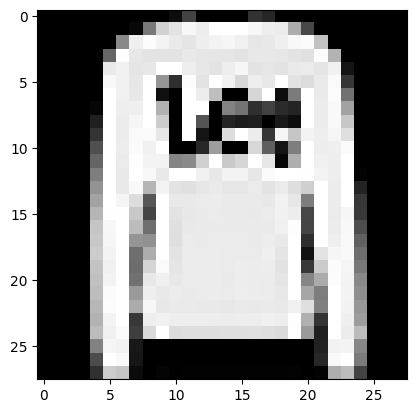

In [ ]:
images, labels = next(iter(val_loader))
img = images[1] # TODO (5d): change this index to look at different images!
plt.imshow(img.squeeze(), cmap='gray')
img_batch = img.unsqueeze(0).to(device) # batch of one to pass through model

First, we look at how each image patch attends to every other image patch. For a given layer, this will give us a size num_image_patches x num_image_patches matrix of attention values.

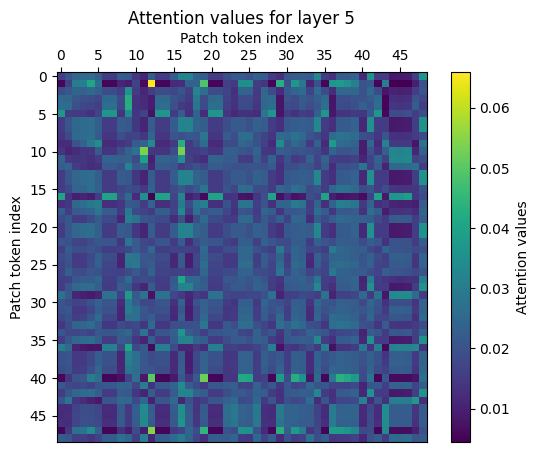

In [ ]:
def visualize_image_attn(attention_matrices, layer_idx):
    attn = attention_matrices[layer_idx, 0, 1:, 1:] # remove the first cls token
    num_patches = attn.shape[0]

    fig, ax = plt.subplots()
    plt.imshow(attn, cmap='viridis')
    plt.title(f'Attention values for layer {layer_idx}')

    ax.set_xticks(np.arange(0, num_patches, 5))
    ax.set_yticks(np.arange(0, num_patches, 5))
    ax.set_xlabel("Patch token index")
    ax.set_ylabel("Patch token index")
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    cbar = plt.colorbar()
    cbar.set_label(f'Attention values')

    plt.show()

transformer.eval()
with torch.no_grad():
    out, attention_matrices = transformer(img_batch, return_attn=True)
    visualize_image_attn(attention_matrices, 5) # TODO (5d): change index to look at different layers

We can also look at the attentions of the classification token only. This consists of num_image_patches attention values for each layer; we'll reshape these values into a square matrix to better compare with the original image.

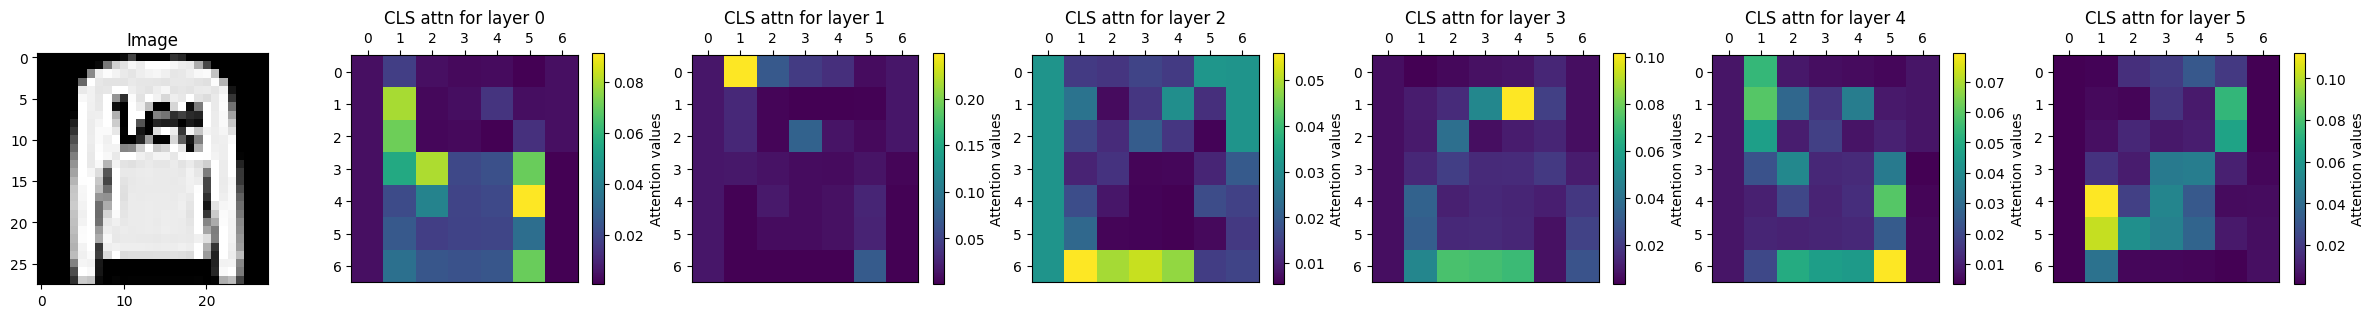

In [ ]:
def visualize_cls_attn(img, attention_matrices):
    attns = attention_matrices[:, 0, 0] # only look at attentions of cls token
    num_ticks = int(np.sqrt(attns.shape[1] - 1))
    attns = attns[:, 1:].reshape((-1, num_ticks, num_ticks)) # reshape to match image

    fig, axes = plt.subplots(1, 7, figsize=(30, 3))
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Image')

    # get cls attention for all layers
    for i in range(6):
        im = axes[i + 1].imshow(attns[i], cmap='viridis')
        axes[i + 1].set_title(f'CLS attn for layer {i}')

        axes[i + 1].set_xticks(np.arange(num_ticks))
        axes[i + 1].set_yticks(np.arange(num_ticks))
        axes[i + 1].xaxis.set_label_position('top')
        axes[i + 1].xaxis.tick_top()

        cbar = fig.colorbar(im, ax=axes[i + 1])
        cbar.set_label(f'Attention values')

    plt.show()

transformer.eval()
with torch.no_grad():
    out, attention_matrices = transformer(img_batch, return_attn=True)
    visualize_cls_attn(img.squeeze(), attention_matrices) # TODO (5d): look at different images